# Model Training (Keras)

## Configuration

In [1]:
# The parameter file is where the hyperparameters are set

from parameters import *

## Library

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-11-13 03:57:41.907813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 03:57:41.907904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 03:57:41.907913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 03:57:41.913768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
seed = 0

# Input seed value. if this value is the same, the random number generator will generate the same set of random values every time
np.random.seed(seed)

# Set the seed value for reproducibility in tensorflow
tf.random.set_seed(seed)

## Check GPU

In [4]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8067130898564642564
xla_global_id: -1
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16301677848105992827
physical_device_desc: "device: XLA_CPU device"
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8502378496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16869666090990744211
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:00:11.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12111689383186355297
physical_device_desc: "device: XLA_GPU device"
xla_global_id: -1
]


2024-11-13 03:57:48.122445: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562f28078570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-13 03:57:48.122505: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-11-13 03:57:48.122639: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-11-13 03:57:48.143964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 03:57:48.173828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least o

## Dataset

### Load

In [5]:
# Keeping DATA_AUGMENTATION 'True' for now so everything scales between 0 and 1
if DATA_AUGMENTATION:
    X_train_val = np.load('{}/npy/x_train_val_augmented.npy'.format(DATA_DIR), allow_pickle=True)
    X_test = np.load('{}/npy/x_test_augmented.npy'.format(DATA_DIR), allow_pickle=True)
    
    y_train_val = np.load('{}/npy/y_train_val_augmented.npy'.format(DATA_DIR), allow_pickle=True)
    y_test = np.load('{}/npy/y_test_augmented.npy'.format(DATA_DIR), allow_pickle=True)  
else:
    X_train_val = np.load('{}/npy/x_train_val.npy'.format(DATA_DIR), allow_pickle=True)
    X_test = np.load('{}/npy/x_test.npy'.format(DATA_DIR), allow_pickle=True)
    
    y_train_val = np.load('{}/npy/y_train_val.npy'.format(DATA_DIR), allow_pickle=True)
    y_test = np.load('{}/npy/y_test.npy'.format(DATA_DIR), allow_pickle=True)

### Visualize

In [6]:
print(y_train_val.shape)
print(X_train_val.shape)
print(y_train_val[0])

(972, 45)
(972, 2)
[0.00000000e+00 0.00000000e+00 4.03940887e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.14285714e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 3.26585020e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30013001e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.00025001e-05 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


In [7]:
display(X_train_val) #can check this in previous script as well after loading to make sure it matches

array([[0.06143168, 0.1222459 ],
       [0.04092692, 0.07230281],
       [0.51113395, 0.00118874],
       ...,
       [0.05754841, 0.25609945],
       [0.57781303, 0.0013409 ],
       [0.06168676, 0.26742149]])

In [8]:
#number of values in the training set and test set, these are probably pulling from the data files individual points

total = len(y_train_val) + len(y_test)
print('---------------------------------------')  
print('Train-and-validation set shape y: {}, {:.2f}%'.format(len(y_train_val), (len(y_train_val)*100.)/total))
print('Test set shape y:                 {}, {:.2f}%'.format(len(y_test), (len(y_test)*100.)/total))
print('---------------------------------------')

total = len(X_train_val) + len(X_test)
print('---------------------------------------')  
print('Train-and-validation set shape x: {}, {:.2f}%'.format(len(X_train_val), (len(X_train_val)*100.)/total))
print('Test set shape x:                 {}, {:.2f}%'.format(len(X_test), (len(X_test)*100.)/total))
print('---------------------------------------')

---------------------------------------
Train-and-validation set shape y: 972, 79.93%
Test set shape y:                 244, 20.07%
---------------------------------------
---------------------------------------
Train-and-validation set shape x: 972, 79.93%
Test set shape x:                 244, 20.07%
---------------------------------------


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

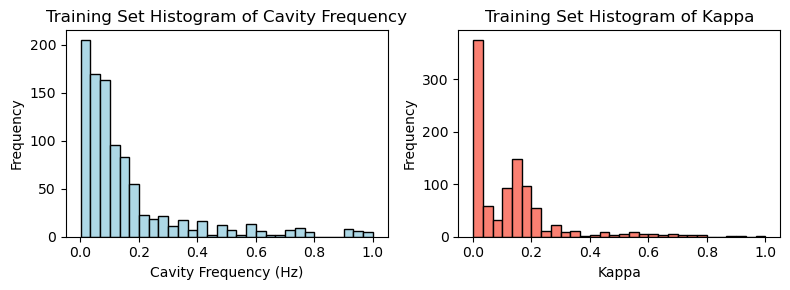

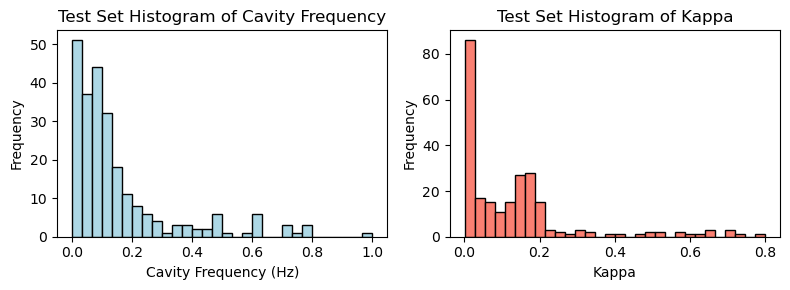

In [10]:
#--------------------Training Set---------------------
plt.figure(figsize=(8, 3))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in X_train_val], bins=30, color='lightblue', edgecolor='black')
plt.title('Training Set Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in X_train_val], bins=30, color='salmon', edgecolor='black')
plt.title('Training Set Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#--------------------Test Set---------------------
plt.figure(figsize=(8, 3))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in X_test], bins=30, color='lightblue', edgecolor='black')
plt.title('Test Set Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in X_test], bins=30, color='salmon', edgecolor='black')
plt.title('Test Set Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## MLP

### Create model

Create a classical multi-layer perceptron for regression: 602 input features, 10 targets, and a certain number of hidden layers and neurons. Taking some inspiration from [Deep learning-based I-V Global Parameter Extraction for BSIM-CMG](https://www.sciencedirect.com/science/article/pii/S003811012300179X), Solid-State Electronics, Vol. 209, November 2023.

Reccomended to download a third party app like "Sleep control Center" or "Amphetamine" to prevent computer from sleeping during the many hour/day long training process

### Create Model by Hand

In [23]:
# Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
model_shape = 'mlp_2_'

# Define the number on neurons in the inner layer (in parameter file)
model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)

# 44 output neurons for 45 parameters
model_shape += '_45'

In [24]:
# Initialize a sequential model, which lets us build a linear stack of layers
model = Sequential()

# Add an input layer to the model. This layer defines the shape of the input data (2 features per sample), sets dimensions of following layers
model.add(Input(shape=(2,), name='input1'))

# Iterate over the configuration of neurons for each hidden layer specified in NEURONS_PER_LAYER
for i, n in enumerate(NEURONS_PER_LAYER):
    # Add a fully connected (dense) hidden layer with spec ified number of neurons
    # The LeCun uniform initializer is used when initializing weights, this makes the model more stable
    # L2 regularization is used in each layer to penalizing large weights, which prevents overfitting
    model.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    # Apply a Leaky ReLU activation function to the outputs of the dense layer
    # This introduces non-linearities, allowing the network to learn complex functions
    # Leaky ReLU is chosen over standard ReLU to help mitigate the "dying ReLU" problem:
    #     - This problem is when neurons using the ReLU activation function output zero for all inputs and stop learning
    #     - Can be mitigated by using variations like Leaky ReLU or proper initialization
    model.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
    
    # Add a dropout layer to reduce overfitting -- randomly drops a set fraction (like 30%) of outputs from the layer
    model.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))

# Add the output layer consisting of 10 neurons, corresponding to the 10 target variables we aim to predict.
# The same LeCun uniform initializer is used to ensure consistency and stability at the output layer as well.
model.add(Dense(45, activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

In [25]:
# The exponential decay learning rate schedule gradually reduces the learning rate, fine-tuning the learning process for better convergence
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR_INITIAL,  
    decay_steps=LR_DECAY_STEPS,        
    decay_rate=LR_DECAY_RATE,          
    staircase=LR_STAIRCASE             
)

# Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
    loss=TRAIN_LOSS,                                         
    metrics=[TRAIN_LOSS]                                     
)

In [26]:
!mkdir -p model
best_model_file = 'model/{}_best_model.h5'.format(model_shape)
last_model_file = 'model/{}_last_model.h5'.format(model_shape)

Enable training (`train_and_save`) to overwrite the model file.

In [27]:
train_and_save = True

We use Adam optimizer, minimize the Mean Squared Logarithmic Error, and early stop.

#### Training

In [28]:
from IPython.display import clear_output

class TrainingPlot(tf.keras.callbacks.Callback):
     
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses 
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses  to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
       
class LearningRateMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateMonitor, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer._current_learning_rate.read_value()
        self.learning_rates.append(lr)
        print(f"Epoch: {epoch + 1}, Learning Rate: {lr:.10f}")

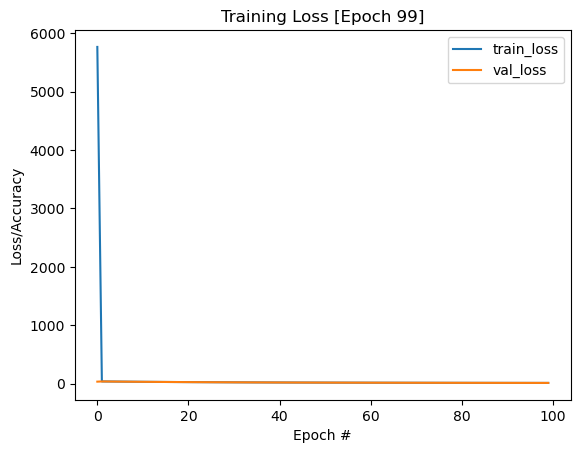

Epoch: 100, Learning Rate: 0.0036551175
25/25 [==============================] - 1s 59ms/step - loss: 10.6550 - mean_squared_error: 0.0108 - val_loss: 10.6164 - val_mean_squared_error: 0.0114
CPU times: user 1min 28s, sys: 1min 11s, total: 2min 40s
Wall time: 2min 23s


In [30]:
%%time
history = None  

if train_and_save: 
    # Set up early stopping to prevent overfitting by halting training when validation loss stops improving
    early_stopping = EarlyStopping(
        monitor='val_loss',                      # Monitor validation loss for stopping criteria 
        mode='min',                              # Stop when the monitored quantity has stopped decreasing
        patience=TRAIN_EARLY_STOPPING_PATIENCE,  # Number of epochs to wait after last improvement
        verbose=1                                # Enable logging when early stopping happens
    )

    # Set up model checkpointing to save the model at its best validation loss:
    model_checkpoint = ModelCheckpoint(
        filepath=best_model_file,          
        monitor='val_loss',            # Save the model based on validation loss improvement
        mode='min',                    # Favor lower validation loss values for saving (minimize)
        save_best_only=True,           # Save only when validation loss improves
        verbose=0                      # No logging for model saving
    )
    
    plot_callback = TrainingPlot()      # Plot training progress
    lr_monitor = LearningRateMonitor()  # Watch learning rate changes

    # Train the model on the training data and validate on a portion of it
    history = model.fit(
        np.asarray(X_train_val),  
        np.asarray(y_train_val),      
        epochs=100,                   
        batch_size=TRAIN_BATCH_SIZE,  
        validation_split=TRAIN_VALIDATION_SPLIT,  
        callbacks=[early_stopping, model_checkpoint, plot_callback, lr_monitor],  
        verbose=1  # Enable logging of the training process.
    )
    
    model.save(last_model_file)  # Save the final model when done training!


Load the saved best model and use it from now on.

In [19]:
model = load_model(best_model_file, custom_objects={})

### Keras Tuner to Find Best Hyperparameters and Model

Run this if you want to use keras tuner to make the model rather than doing it by hand

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model

In [37]:
def build_hypermodel(hp):
    # Hyperparameters to tune
    neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
    dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
    
    # Create Model in the same way that we do by hand
    model = Sequential()
    model.add(Input(shape=(2,), name='input1'))

    for i, n in enumerate(neurons_per_layer):
        model.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
        model.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))

    model.add(Dense(45, name='output', kernel_initializer='lecun_uniform'))

    # Learning rate configuration
    lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr_initial,
        decay_steps=LR_DECAY_STEPS,
        decay_rate=LR_DECAY_RATE,
        staircase=LR_STAIRCASE
    )

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [38]:
# Start tuning
tuner = RandomSearch(
    build_hypermodel,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='hyper_tuning',
    project_name='mlp_tuning'
)

Reloading Tuner from hyper_tuning/mlp_tuning/tuner0.json


In [39]:
# Setup Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=TRAIN_EARLY_STOPPING_PATIENCE,
    verbose=1
)

In [40]:
# Perform hyperparameter tuning
tuner.search(np.asarray(X_train_val), 
             np.asarray(y_train_val), 
             epochs=50, 
             batch_size=TRAIN_BATCH_SIZE, 
             validation_split=TRAIN_VALIDATION_SPLIT, 
             callbacks=[early_stopping], 
             verbose=1)

Trial 16 Complete [00h 02m 22s]
val_loss: 2.5359950065612793

Best val_loss So Far: 0.027076425030827522
Total elapsed time: 00h 34m 41s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
2000              |300               |neurons_0
2000              |1000              |neurons_1
1500              |5000              |neurons_2
5000              |1900              |neurons_3
0.2               |0.4               |dropout_rate
0.00096022        |0.0017684         |learning_rate

Epoch 1/50
25/25 [==============================] - 2s 24ms/step - loss: 7.0153 - mean_squared_error: 0.1275 - val_loss: 4.1137 - val_mean_squared_error: 0.0658
Epoch 2/50
25/25 [==============================] - 1s 28ms/step - loss: 3.1457 - mean_squared_error: 0.0539 - val_loss: 2.4659 - val_mean_squared_error: 0.0313
Epoch 3/50
25/25 [==============================] - 1s 27ms/step - loss: 2.2155 - mean_squared_error: 0.0213 - val_loss: 2.0031 - val_mean_squared_error: 0.0141
Epo

KeyboardInterrupt: 

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model)

In [ ]:
best_model_file = 'model/best_keras_model.h5'
best_model.save(best_model_file)

model = load_model(best_model_file)

### View the model

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 3300)              1989900   
                                                                 
 leaky_relu0 (LeakyReLU)     (None, 3300)              0         
                                                                 
 dropout0 (Dropout)          (None, 3300)              0         
                                                                 
 fc1 (Dense)                 (None, 1600)              5281600   
                                                                 
 leaky_relu1 (LeakyReLU)     (None, 1600)              0         
                                                                 
 dropout1 (Dropout)          (None, 1600)              0         
                                                                 
 fc2 (Dense)                 (None, 2100)              3

In [39]:
tf.keras.utils.plot_model(model, to_file='{}_model.png'.format(model_shape), show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

In [ ]:
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

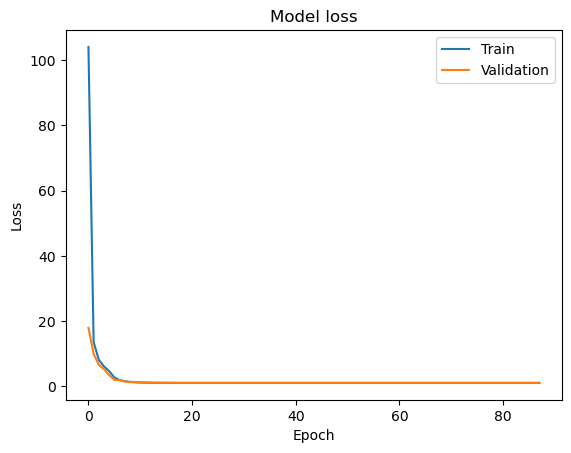

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

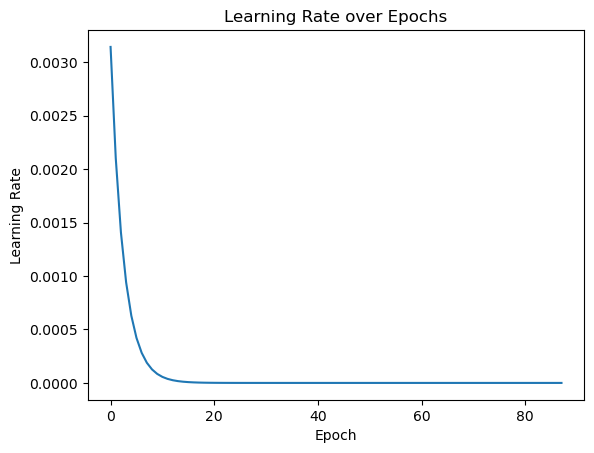

In [21]:
plt.plot(lr_monitor.learning_rates)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

Measure and print metrics.

In [22]:
test_loss_result = model.evaluate(np.asarray(lin_log_X_test), np.asarray(y_test))[0]
print(y_test[0])
print(test_loss_result)

1250/1250 [==============================] - 2s 2ms/step - loss: 1.0287 - mean_squared_error: 0.7496
[ 1.0259    2.3879    1.2497    6.2514    1.0404    1.3463    0.023697
 19.098     2.1097    2.0468  ]
1.0287261009216309


In [23]:
print('Current loss {}: {}'.format(TRAIN_LOSS, test_loss_result))

Current loss mean_squared_error: 1.0287261009216309


In [24]:
import csv

csv_data = [[
    PARAM,
    DATA_AUGMENTATION,
    model_shape,
    test_loss_result,
    TRAIN_LOSS,
    TRAIN_DROPOUT_RATE,
    TRAIN_EARLY_STOPPING_PATIENCE,
    TRAIN_BATCH_SIZE,
    TRAIN_VALIDATION_SPLIT,
    LR_INITIAL,
    LR_DECAY_STEPS,
    LR_DECAY_RATE,
    LR_STAIRCASE
    ]]

csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh

if not os.path.exists(csv_file):
    with open(csv_file, 'w') as file:
        file.write('data_param,data_augmentation,data_x_scaled, data_y_scaled,model_shape,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

# Convert data to DataFrame for easier display
df = pd.read_csv(csv_file)

def color_red_column(s):
    return ['color: red' if v else '' for v in s]

styled_df = df.style.apply(color_red_column, subset=['test_loss'])

# Display the DataFrame as a table
display(styled_df)
#qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

In [25]:
y_pred = model.predict(np.array(lin_log_X_test))

1250/1250 [==============================] - 2s 1ms/step


In [26]:
paramNames = ['phig1', 'u0', 'rdw', 'rsw', 'ua', 'ud', 'ucs', 'cit', 'prwg', 'eu']
pow2_errors = [(y_test[i]-y_pred[i][0])**2 for i in range(len(y_pred))]
abs_errors = [abs(y_test[i]-y_pred[i][0]) for i in range(len(y_pred))]
min=1
for i in range(2): 
    if abs_errors[i].any()<min: 
        min = abs_errors[i]
    print("IV curve #: " + str(i+1))
    for l in range(len(y_test[i])):
        print('Param: {}, Ref: {}, Pred: {}, Pow2Er: {}, AbsEr: {}'.format(paramNames[l],y_test[i][l], y_pred[i][l], pow2_errors[i][l], abs_errors[i][l]))
    print("")

IV curve #: 1
Param: phig1, Ref: 1.0259, Pred: 1.0223517417907715, Pow2Er: 1.2590136319357794e-05, AbsEr: 0.0035482582092285497
Param: u0, Ref: 2.3879, Pred: 2.351001024246216, Pow2Er: 1.8647220454982583, AbsEr: 1.3655482582092286
Param: rdw, Ref: 1.2497, Pred: 1.268797516822815, Pow2Er: 0.05168723051077006, AbsEr: 0.22734825820922855
Param: rsw, Ref: 6.2514, Pred: 5.944940090179443, Pow2Er: 27.34294568668097, AbsEr: 5.229048258209229
Param: ua, Ref: 1.0404, Pred: 0.67220538854599, Pow2Er: 0.0003257396243869842, AbsEr: 0.018048258209228507
Param: ud, Ref: 1.3463, Pred: 1.4692116975784302, Pow2Er: 0.10494247399679302, AbsEr: 0.32394825820922857
Param: ucs, Ref: 0.023697, Pred: 0.1952643245458603, Pow2Er: 0.9973112933011925, AbsEr: 0.9986547417907715
Param: cit, Ref: 19.098, Pred: 17.50562286376953, Pow2Er: 326.7290599545023, AbsEr: 18.075648258209227
Param: prwg, Ref: 2.1097, Pred: 2.669267177581787, Pow2Er: 1.1823262346306433, AbsEr: 1.0873482582092286
Param: eu, Ref: 2.0468, Pred: 2.6

## Compare predictions vs. test set

In [30]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [31]:
#abs_errors is now a list of 2d arrays like array([0.01318291, 4.47633068]) with the two values
phig1_abs_errors = [arr[0] for arr in abs_errors]
u0_abs_errors = [arr[1] for arr in abs_errors]
rdw_abs_errors = [arr[2] for arr in abs_errors]
rsw_abs_errors = [arr[3] for arr in abs_errors]
ua_abs_errors = [arr[4] for arr in abs_errors]
ud_abs_errors = [arr[5] for arr in abs_errors]
ucs_abs_errors = [arr[6] for arr in abs_errors]
cit_abs_errors = [arr[7] for arr in abs_errors]
prwg_abs_errors = [arr[8] for arr in abs_errors]
eu_abs_errors = [arr[9] for arr in abs_errors]

In [32]:
def normalize_errors(errors):
    max_error = max(errors)
    return [error / max_error for error in errors]

def plot_3d_scatter(X_test_unscaled, errors, parameter_name, filename):
    norm_errors = [error / max(errors,) for error in errors] #normalize everything
    # Create a colormap object
    cmap = cm.get_cmap('viridis')
    # Generate the list of color values
    color_values = [cmap(norm_error) for norm_error in norm_errors]
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    for i in range(len(X_test)):
        color = cmap(i)
        Vg = X_test_unscaled[i][0]
        Vd = X_test_unscaled[i][1]
        Id = X_test_unscaled[i][2][:301] #just grab the first set which is linear and plot
        ax.scatter(Vg, Vd, Id, color=color_values[i], label='Prediction', depthshade=False,s=1)
    _ = ax.set_xlabel('Vg (gate voltage)')
    _ = ax.set_ylabel('Vd (drain voltage)')
    _ = ax.set_zlabel('Id (drain current)')
    _ = ax.set_title('Parameter: ' + parameter_name)
    cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.25)  # Shrink the colorbar
    cbar.set_label('Absolute Error (darker = less, lighter = more)', fontsize='8')
    cbar.mappable.set_clim(vmin=np.min(errors,), vmax=np.max(errors,))
    fig.savefig(f'plots/{filename}.png')
    plt.close()

In [33]:
plot_3d_scatter(X_test, u0_abs_errors, 'u0', 'u0errs')
plot_3d_scatter(X_test, phig1_abs_errors, 'phig1', 'phig1errs')
plot_3d_scatter(X_test, rdw_abs_errors, 'rdw', 'rdwerrs')
plot_3d_scatter(X_test, rsw_abs_errors, 'rsw', 'rswerrs')
plot_3d_scatter(X_test, ucs_abs_errors, 'ucs', 'ucserrs')
plot_3d_scatter(X_test, ud_abs_errors, 'ud', 'uderrs')
plot_3d_scatter(X_test, cit_abs_errors, 'cit', 'citerrs')
plot_3d_scatter(X_test, prwg_abs_errors, 'prwg', 'prwgerrs')
plot_3d_scatter(X_test, eu_abs_errors, 'eu', 'euerrs')
plot_3d_scatter(X_test, u0_abs_errors, 'u0', 'u0errs')

/var/folders/z7/t6wp9zrj1ng1v25l8khm54yc0000j7/T/ipykernel_9880/4138828381.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
